In [1]:
!python3.11 -m pip install yfinance numpy pandas scipy matplotlib openpyxl

In [2]:
#Required Packages
import yfinance as yf
import numpy as np
import pandas as pd
import warnings
from pandas.errors import Pandas4Warning
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [23]:
#Loading Stocks from given excel sheet
excel_sheet = "stocks.xlsx"
sheet_name = "Sheet1"
ticker_column = "Tickers"

df = pd.read_excel(path, sheet_name=sheet_name);
tickers = df[ticker_col].dropna().tolist()

In [4]:
#Pulling data for each ticker
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365*3)).strftime('%Y-%m-%d')

print(f"Fetching Data for {len(tickers)} tickers")
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)

price_df = data['Close'].dropna(axis=1)
tickers = price_df.columns.tolist()
print(price_df.head())

warnings.filterwarnings('ignore', category=Pandas4Warning)

Fetching Data for 8 tickers


/opt/homebrew/lib/python3.11/site-packages/yfinance/scrapers/history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
[*********************100%***********************]  8 of 8 completed

Ticker            AMZN          AZO        FLUT         MAR       MNST  \
Date                                                                     
2023-01-24   96.320000  2341.560059  163.000000  164.598770  51.509998   
2023-01-25   97.180000  2357.810059  155.000000  167.218658  51.759998   
2023-01-26   99.220001  2415.270020  157.375000  169.401917  51.955002   
2023-01-27  102.239998  2369.340088  151.229996  169.159348  51.395000   
2023-01-30  100.550003  2428.580078  155.429993  166.122177  51.185001   

Ticker            TJX        WMT        XLP  
Date                                         
2023-01-24  77.992119  45.960991  67.469528  
2023-01-25  79.287186  45.742470  67.635544  
2023-01-26  79.104904  45.700695  67.395737  
2023-01-27  78.558105  46.050983  67.202034  
2023-01-30  78.193588  45.681404  67.285049  


# Risk Parity Portfolio Optimization

In [5]:
# Calculate percentage returns
returns = price_df.pct_change().dropna()

# Creating a correlation matrix for HERC
corr_matrix = returns.corr()

# Annualized covariance matrix
annualized_cov_matrix = returns.cov() * 252

# Regularize covariance for numerical stability
length = annualized_cov_matrix.shape[0]
cov_matrix = annualized_cov_matrix + (np.eye(length) * 1e-6)

In [6]:
def min_mse(weights, cov_matrix):
    # Calculating the portfolio variance
    portfolio_risk = np.sqrt(weights @ cov_matrix @ weights)
    
    # Calculating the relation of how much portfolio risk changes if increased any assets weighting
    marginal_contrib = cov_matrix @ weights
    
    # Calculating the risk contribution of each asset
    risk_contrib = weights * marginal_contrib / portfolio_risk

    # Calculating the MSE
    return np.sum((risk_contrib - np.mean(risk_contrib)) ** 2)

In [7]:
# Optimizing weightings
length = len(cov_matrix)

# Assuming inital assets have an equal weight
init_weights = np.ones(length) / length

# Constraints - ensures that the total weighting sums to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
# Bounds - so the optimizer does not suggest short selling, long-only
bounds = tuple((0, 1) for _ in range(length))

optimize = minimize(min_mse, # The function to minimize weights
                   init_weights, # Starting point
                   args=(cov_matrix,), # Additional argument to put in the min_mse function
                   method='SLSQP', # Optimize method, using because we have constraints and bounds
                   bounds=bounds, 
                   constraints=constraints,
                   options={'maxiter': 1000}) # Allowing sufficient iterations for convergence

In [8]:
rp_weights = optimize.x
rp_weights.sum() # Check to make sure weighting distrubtion adds to 1

np.float64(1.0)

In [9]:
# Adding updated weights to excel in a new column
# Will be used later for testing and visualization
rp_w = pd.Series(rp_weights, index=price_df.columns, name="After - Risk Parity")
rp_w.head()

df[rp_w.name] = df[ticker_col].map(rp_w)

with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    df.to_excel(writer, sheet_name=sheet_name, index=False)

print("Added Updated Weights to Excel Sheet")

Added Updated Weights to Excel Sheet


# Hierarchical Risk Parity (HRP) Portfolio Optimization

In [10]:
# Importing additional packages
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

In [11]:
def cluster_var(cov, cluster):
    # Getting a sub-covariance matrix the cluster
    cov_slice = cov[np.ix_(cluster, cluster)]

    # Getting the diagonal - lower variance get higher weights since 1/smaller > 1/larger
    diag = np.diag(cov_slice)
    inv_diag = 1.0 / diag

    # Normalizing these weights
    inv_diag = inv_diag / inv_diag.sum()
    
    # Reshape for vector math
    w = inv_diag.reshape(-1, 1)
    
    # Calculating the clusters variance doing w^T * Cov * W
    return float(w.T @ cov_slice @ w)

def get_leaves(cluster_id, Z, n):
    # Base case
    if cluster_id < n:
        return [cluster_id]
        
    # If not, then split tree in half again
    left = int(Z[cluster_id - n, 0])
    right = int(Z[cluster_id - n, 1])

    # Recursively collects the leaves from both sides
    return get_leaves(left, Z, n) + get_leaves(right, Z, n)

def hrp_allocate(cov, Z):
    n = cov.shape[0]
    
    # Initialized same weightings 
    w = np.ones(n)

    def recurse(cluster_id):
        # Base case
        if cluster_id < n:
            return

        # Get child cluster from linkage tree
        left = int(Z[cluster_id - n, 0])
        right = int(Z[cluster_id - n, 1])

        # Retrive the next asset in the cluster
        left_leaves = get_leaves(left, Z, n)
        right_leaves = get_leaves(right, Z, n)

        # Compute the cluster variance
        left_var = cluster_var(cov, left_leaves)
        right_var = cluster_var(cov, right_leaves)

        # Allocate more weighting for the lower-variance cluster
        alpha = right_var / (left_var + right_var)

        # Applying weightings to both sides respectively
        w[left_leaves] *= alpha
        w[right_leaves] *= (1 - alpha)
        
        recurse(left)
        recurse(right)

    # Root node of the dendrogram
    root = 2 * n - 2
    recurse(root)

    # Normalize weights to sum to 1
    return w / w.sum()

/var/folders/7_/138wbpmx02zfdb_585wmqlqc0000gn/T/ipykernel_40886/1295552630.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(w.T @ cov_slice @ w)


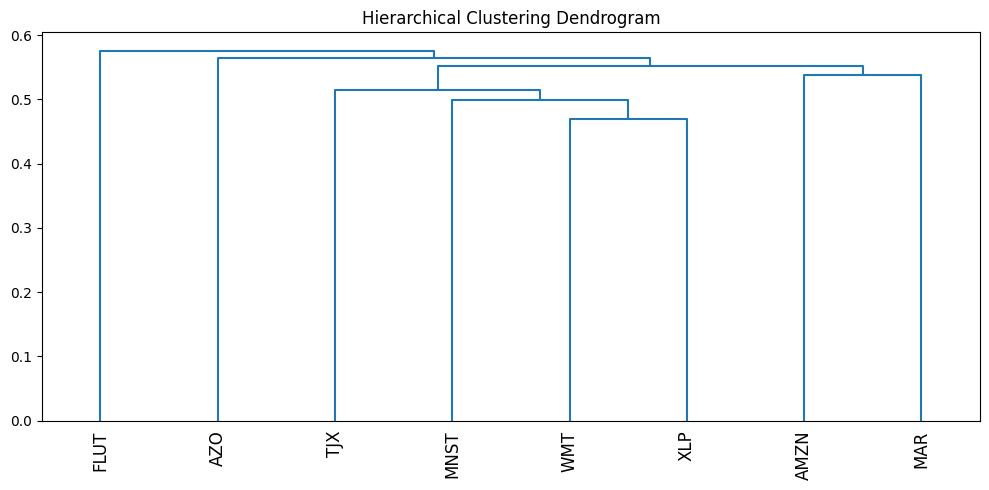

1.0


In [14]:
# Converting the correlation matrix to a clustering distance matrix
dist = np.sqrt((1 - corr_matrix.values) / 2)

# Running a hierarchical clustering algorithm 
dist_condensed = squareform(dist, checks = False)
Z = linkage(dist_condensed, method="single")

n = len(price_df.columns)
herc_weights = np.ones(n)

# Creating fully optimized weights
herc_weights = hrp_allocate(annualized_cov_matrix.values, Z)

# Visualizing the quasi diagram
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=price_df.columns, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.tight_layout()
plt.show()
print(herc_weights.sum())

In [34]:
# Adding updated weights to excel in a new column
# Will be used later for testing and visualization
herc_w = pd.Series(herc_weights, index=price_df.columns, name="After - HRP")

df[herc_w.name] = df[ticker_col].map(herc_w)

with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    df.to_excel(writer, sheet_name=sheet_name, index=False)

print("Added Updated Weights to Excel Sheet")

Added Updated Weights to Excel Sheet


In [61]:
def calculate_portfolio_performance(weights, returns, risk_free_rate=0.02):
    portfolio_returns = (returns * weights).sum(axis=1)

    annual_return = portfolio_returns.mean() * 252
    annual_volatility = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

    cumulative_returns = (1 + portfolio_returns).cumprod()

    metrics = {
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Portfolio Returns": portfolio_returns,
        "Cumulative Returns": cumulative_returns
    }

    return metrics

def backtest_portfolio(weights, tickers, prices, returns, risk_free_rate=0.02, initial_capital=10000):
    metrics = calculate_portfolio_performance(weights, returns, risk_free_rate)
    portfolio_value = initial_capital * metrics["Cumulative Returns"]

    results = {
        "weights": weights,
        "tickers": tickers,
        "metrics": metrics,
        "portfolio_value": portfolio_value,
        "initial_capital": initial_capital
    }

    return results

def downside_deviation(r: pd.Series, mar_annual: float = 0.0, trading_days: int = 252) -> float:
    r = r.dropna()
    if len(r) == 0: return np.nan
    mar_d = mar_annual / trading_days
    downside = np.minimum(r - mar_d, 0.0)
    return np.sqrt(np.mean(downside**2)) * np.sqrt(trading_days)

def sortino_ratio(r: pd.Series, rf_annual: float = 0.045, mar_annual: float = 0.0, trading_days: int = 252) -> float:
    r = r.dropna()
    if len(r) < 2: return np.nan
    ann_ret = r.mean() * trading_days
    dd = downside_deviation(r, mar_annual=mar_annual, trading_days=trading_days)
    return np.nan if (not np.isfinite(dd) or dd <= 0) else (ann_ret - rf_annual) / dd

def summarize_and_plot(results_dict: dict, rf_annual: float = 0.045, trading_days: int = 252, mar_annual: float = 0.0):
    # common date index
    common = None
    for res in results_dict.values():
        idx = res["portfolio_value"].dropna().index
        common = idx if common is None else common.intersection(idx)
    if common is None or len(common) == 0:
        raise ValueError("No overlapping dates across strategies.")

    # cumulative % returns (0..100 scale)
    cum_pct = pd.DataFrame({
        name: (res["portfolio_value"].reindex(common) / res["initial_capital"] - 1.0) * 100
        for name, res in results_dict.items()
    })

    # summary metrics
    rows = []
    for name, res in results_dict.items():
        m = res["metrics"]
        ann_ret = float(m["Annual Return"])
        ann_vol = float(m["Annual Volatility"])
        risk_adj = (ann_ret - rf_annual) / ann_vol if ann_vol > 0 else np.nan

        port_rets = m["Portfolio Returns"] 
        sortino = sortino_ratio(port_rets, rf_annual=rf_annual, mar_annual=mar_annual, trading_days=trading_days)

        rows.append({
            "Strategy": name,
            "Annual Return": ann_ret,
            "Annual Vol": ann_vol,
            "Risk Adj (Excess/Vol)": risk_adj,
            "Sortino": sortino
        })

    summary_df = pd.DataFrame(rows).set_index("Strategy")

    # format for display table
    disp = summary_df.copy()
    disp["Annual Return"] = disp["Annual Return"].map(lambda x: f"{x:.2%}" if np.isfinite(x) else "—")
    disp["Annual Vol"] = disp["Annual Vol"].map(lambda x: f"{x:.2%}" if np.isfinite(x) else "—")
    disp["Risk Adj (Excess/Vol)"] = disp["Risk Adj (Excess/Vol)"].map(lambda x: f"{x:.3f}" if np.isfinite(x) else "—")
    disp["Sortino"] = disp["Sortino"].map(lambda x: f"{x:.3f}" if np.isfinite(x) else "—")

    # plot + table
    fig = plt.figure(figsize=(16, 5))

    ax1 = fig.add_subplot(1, 2, 1)
    cum_pct.plot(ax=ax1, linewidth=2)
    ax1.set_title("Cumulative Returns (All Strategies)")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Cumulative Return (%)")
    ax1.legend()
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.axis("off")
    tbl = ax2.table(
        cellText=disp.values,
        rowLabels=disp.index,
        colLabels=disp.columns,
        cellLoc="center",
        loc="center",
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9.5)
    tbl.scale(1.05, 1.6)
    ax2.set_title("Performance Summary (Sortino)")

    plt.tight_layout()
    plt.show()

    return summary_df

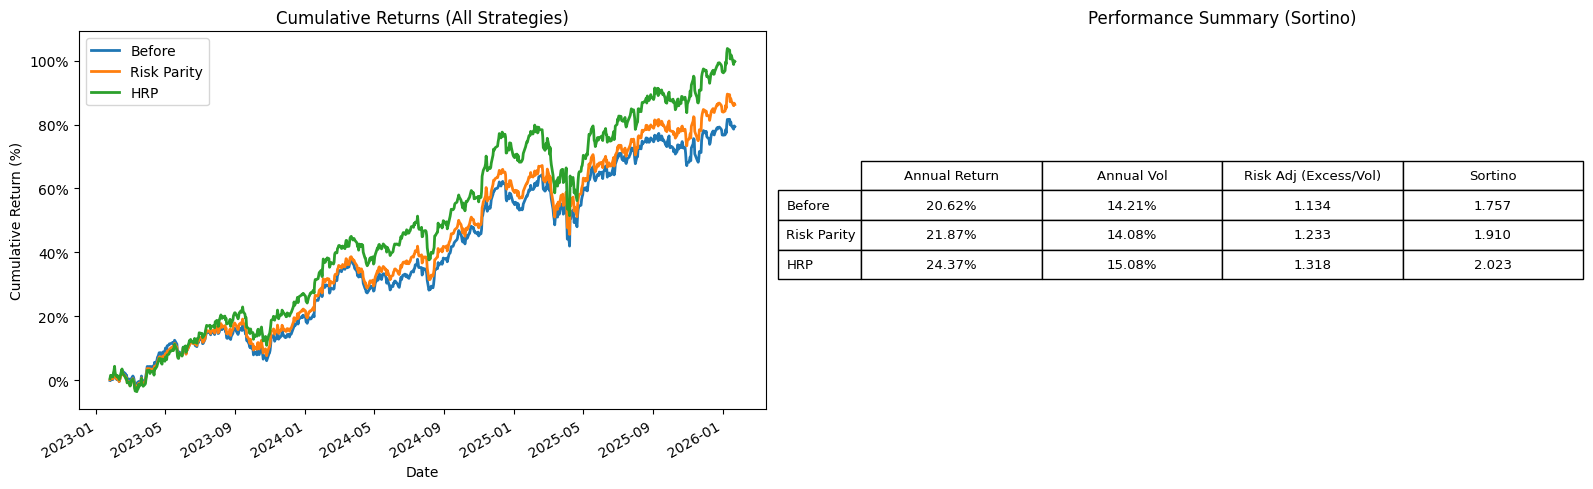

In [62]:
before_results = backtest_portfolio(w_before, tickers, price_df, returns, risk_free_rate=0.045, initial_capital=10000)
rp_results     = backtest_portfolio(w_rp, tickers, price_df, returns, risk_free_rate=0.045, initial_capital=10000)
herc_results   = backtest_portfolio(w_herc, tickers, price_df, returns, risk_free_rate=0.045, initial_capital=10000)

results_dict = {
    "Before": before_results,
    "Risk Parity": rp_results,
    "HRP": herc_results
}

summary_df = summarize_and_plot(results_dict, rf_annual=0.045, trading_days=252, mar_annual=0.0)